# Predict Baseball Strike Zones

In this project, we will use a Support Vector Machine Model trained using a [`pybaseball`](https://github.com/jldbc/pybaseball) dataset to find the decision boundary of the strike zone. 

The strike zone can be thought of as a decision boundary itself, because it determines whether a pitch is a strike or a ball. There is a strict definition of the strike zone. A pitch is considered a strike if it passes through the strike zone (regardless if the batter swings at the pitch or not) and travels over home plate.  A pitch is considered a ball if it does NOT pass through the strike zone and the batter does NOT swing at the pitch. However, in practice, it will vary depending on the umpire or the player at bat. Considering this, we'll use SVMs to find the real strike zone of specific baseball players. 

SVMs are those exact machine learning models that can make complex decision boundaries - they can twist and curve them to accommodate the training data. As a result, our decision boundaries will be both informative and flexible. 

Let's start with necessary imports and data exploration.

## Exploring the Data

In [77]:
# Basic imports related to analysis
import pandas as pd

# Imports for visualisationin
import seaborn as sns
import matplotlib.pyplot as plt

# Imports for ml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Data import
import pybaseball
from pybaseball import statcast
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher

We are going to use `pybaseball`'s `statcast` table filtered by `player_name` as a source of our data. The statcast function retrieves pitch-level statcast data for a given date or range or dates. Let's upload the slice of `statcast` from 01.01.22 till 13.09.22. 

In [2]:
pybaseball.cache.enable()
stats = statcast(start_dt='2022-01-01', end_dt='2022-09-13')
stats.head()

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 183/183 [00:06<00:00, 26.35it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3213,FF,2022-09-13,96.3,-2.25,4.6,"Kimbrel, Craig",572233,518886,field_out,hit_into_play,...,4,4,0,0,4,Infield shift,Standard,222,-0.001,-0.118
3299,FF,2022-09-13,95.7,-2.24,4.74,"Kimbrel, Craig",572233,518886,None,swinging_strike,...,4,4,0,0,4,Infield shift,Standard,219,0.0,-0.022
3428,KC,2022-09-13,85.4,-2.47,4.71,"Kimbrel, Craig",572233,518886,None,ball,...,4,4,0,0,4,Infield shift,Standard,62,0.0,0.023
3576,FF,2022-09-13,95.8,-2.31,4.81,"Kimbrel, Craig",572233,518886,None,ball,...,4,4,0,0,4,Infield shift,Standard,218,0.0,0.016
3600,FF,2022-09-13,95.9,-2.42,4.7,"Kimbrel, Craig",664983,518886,field_out,hit_into_play,...,4,4,0,0,4,Infield shift,Standard,223,-0.005,-0.137


Now let's find in this dataset and filter out as separate variables the data of one of the tallest (`Adam Wainwright`), one of the shortest (`Marcus Stroman`), and one of medium high (`Craig Kimbrel`) players. The idea behind importing info depending on players' heights is that their strike zones should be different due to the difference in their physical parameters.

In [3]:
tallest = stats[stats.player_name == 'Wainwright, Adam']
tallest.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
11,CU,2022-09-08,72.9,-1.01,6.46,"Wainwright, Adam",443558,425794,field_out,hit_into_play,...,4,4,4,4,4,Standard,Standard,46,0.065,-0.495
16,CU,2022-09-08,73.5,-1.12,6.47,"Wainwright, Adam",443558,425794,None,called_strike,...,4,4,4,4,4,Standard,Standard,46,0.0,-0.099
21,SI,2022-09-08,87.7,-1.18,6.27,"Wainwright, Adam",443558,425794,None,ball,...,4,4,4,4,4,Standard,Standard,204,0.0,0.049
24,CU,2022-09-08,74.4,-1.08,6.33,"Wainwright, Adam",443558,425794,None,blocked_ball,...,4,4,4,4,4,Standard,Standard,50,0.0,0.058
29,CH,2022-09-08,81.0,-1.34,6.32,"Wainwright, Adam",660688,425794,single,hit_into_play,...,4,4,4,4,4,Infield shift,Standard,226,-0.019,0.73


In [4]:
shortest = stats[stats.player_name == 'Stroman, Marcus']
shortest.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
262,FC,2022-09-10,87.6,-1.29,5.18,"Stroman, Marcus",573262,573186,strikeout,swinging_strike_blocked,...,2,4,2,4,2,Infield shift,Standard,90,0.028,-0.261
280,FC,2022-09-10,89.7,-0.98,5.16,"Stroman, Marcus",573262,573186,None,foul,...,2,4,2,4,2,Infield shift,Standard,145,0.0,0.0
312,SI,2022-09-10,92.9,-0.85,5.09,"Stroman, Marcus",573262,573186,None,foul,...,2,4,2,4,2,Infield shift,Standard,216,0.0,0.0
343,FC,2022-09-10,90.6,-0.99,5.13,"Stroman, Marcus",573262,573186,None,foul,...,2,4,2,4,2,Infield shift,Standard,194,0.0,-0.077
357,FC,2022-09-10,90.4,-1.0,5.05,"Stroman, Marcus",573262,573186,None,called_strike,...,2,4,2,4,2,Infield shift,Standard,207,0.0,-0.042


In [5]:
medium = stats[stats.player_name == 'Kimbrel, Craig']
medium.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3213,FF,2022-09-13,96.3,-2.25,4.6,"Kimbrel, Craig",572233,518886,field_out,hit_into_play,...,4,4,0,0,4,Infield shift,Standard,222,-0.001,-0.118
3299,FF,2022-09-13,95.7,-2.24,4.74,"Kimbrel, Craig",572233,518886,None,swinging_strike,...,4,4,0,0,4,Infield shift,Standard,219,0.0,-0.022
3428,KC,2022-09-13,85.4,-2.47,4.71,"Kimbrel, Craig",572233,518886,None,ball,...,4,4,0,0,4,Infield shift,Standard,62,0.0,0.023
3576,FF,2022-09-13,95.8,-2.31,4.81,"Kimbrel, Craig",572233,518886,None,ball,...,4,4,0,0,4,Infield shift,Standard,218,0.0,0.016
3600,FF,2022-09-13,95.9,-2.42,4.7,"Kimbrel, Craig",664983,518886,field_out,hit_into_play,...,4,4,0,0,4,Infield shift,Standard,223,-0.005,-0.137


In [6]:
stats.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

There are a lot of columns in this dataset, we won't need all of them. We’re interested in looking at whether a pitch was a "ball" or a "strike". That information should be stored in the `type` column. Let's take a look at the unique values stored in it.

In [7]:
tallest.type.unique()

array(['X', 'S', 'B'], dtype=object)

The types should be the same for all players, either an `S` for a strike, a `B` for a ball, or an `X` for neither (for example, an `X` could be a hit or an out).

In [8]:
shortest.type.unique()

array(['S', 'B', 'X'], dtype=object)

We want to predict whether a pitch is a ball or a strike based on its location over the plate. We can find the ball’s location in the columns `plate_x` and `plate_z`. 

`plate_x` measures how far left or right the pitch is from the center of home plate. If `plate_x = 0`, that means the pitch was directly in the middle of the home plate.

`plate_z` measures how high off the ground the pitch was. If `plate_z = 0`, that means the pitch was at ground level when it got to the home plate.

In [9]:
tallest.plate_x.unique()

<FloatingArray>
[-0.24, -0.27,  -1.8,  1.99, -0.76,  0.18, -0.25,  1.24,  0.49,  0.89,
 ...
   1.5, -1.84, -2.13, -2.16, -1.65,  1.72, -1.57, -2.12, -1.77,  <NA>]
Length: 400, dtype: Float64

In [10]:
tallest.plate_z.unique()[-10:]

<FloatingArray>
[4.18, 0.71, 0.18, 4.74, -0.73, -0.3, 4.22, 4.41, 0.03, <NA>]
Length: 10, dtype: Float64

We now have the three columns we want to work with: 'plate_x', 'plate_z', and 'type'. Let's remove all other columns from all three variables. 

In [11]:
tallest_feat = tallest[['type', 'plate_x', 'plate_z']].reset_index(drop=True)
shortest_feat = tallest[['type', 'plate_x', 'plate_z']].reset_index(drop=True)
medium_feat = tallest[['type', 'plate_x', 'plate_z']].reset_index(drop=True)

medium_feat.head()

,type,plate_x,plate_z
0,X,-0.24,2.55
1,S,-0.27,2.7
2,B,-1.8,3.36
3,B,1.99,-0.14
4,X,-0.76,3.78



## Create Labels

We’ll want to use `type` feature values as labels for our data points. However, instead of using strings we'll change every 'S' to a 1 and every 'B' to a 0, X will be left as `NaN` and we'll remove all such values on the next step.

In [12]:
tallest_feat.type = tallest_feat.type.map({'S':1, 'B':0})
shortest_feat.type = shortest_feat.type.map({'S':1, 'B':0})
medium_feat.type = medium_feat.type.map({'S':1, 'B':0})

tallest_feat.head()

,type,plate_x,plate_z
0,NaN,-0.24,2.55
1,1.0,-0.27,2.7
2,0.0,-1.8,3.36
3,0.0,1.99,-0.14
4,NaN,-0.76,3.78


Let’s remove every row that has a `NaN` in any of those columns.

In [13]:
tallest_feat = tallest_feat.dropna(subset = ['type', 'plate_x', 'plate_z'])
shortest_feat = shortest_feat.dropna(subset = ['type', 'plate_x', 'plate_z'])
medium_feat = medium_feat.dropna(subset = ['type', 'plate_x', 'plate_z'])

tallest_feat.plate_z.unique()[-10:]

<FloatingArray>
[0.71, 1.19, 0.18, 4.74, -0.73, -0.3, 4.22, 4.41, 0.03, 3.21]
Length: 10, dtype: Float64

In [14]:
tallest_feat.head()

,type,plate_x,plate_z
1,1.0,-0.27,2.7
2,0.0,-1.8,3.36
3,0.0,1.99,-0.14
6,1.0,-0.25,2.17
7,0.0,1.24,2.28


## Plotting the pitches



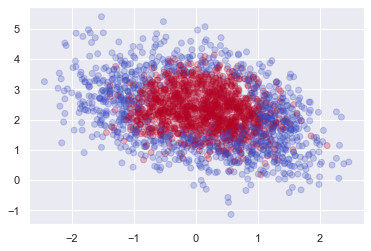

In [48]:
sns.set(style='darkgrid')
plt.scatter(tallest_feat.plate_x, tallest_feat.plate_z, c = tallest_feat.type, cmap = plt.cm.coolwarm, alpha = 0.25) 

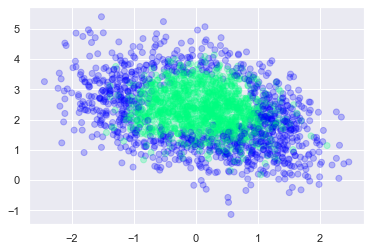

In [55]:
plt.scatter(shortest_feat.plate_x, shortest_feat.plate_z, c = shortest_feat.type, cmap = plt.cm.winter, alpha = 0.25) 

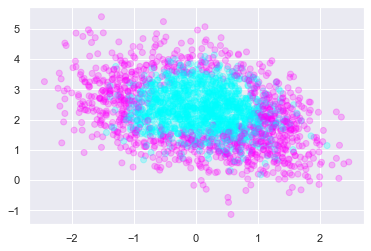

In [58]:
plt.scatter(medium_feat.plate_x, medium_feat.plate_z, c = medium_feat.type, cmap = plt.cm.cool_r, alpha = 0.25) 

## Building the SVM

Now that we’ve seen the location of every pitch, let’s create an SVM to create a decision boundary. This decision boundary will be the real strike zone for that player. To begin, we want to validate our model, so we need to split the data into a training set and a validation set.

In [60]:
training_set1, validation_set1 = train_test_split(tallest_feat, random_state = 1) 
training_set2, validation_set2 = train_test_split(shortest_feat, random_state = 2) 
training_set3, validation_set3 = train_test_split(shortest_feat, random_state = 2) 

Now let's train models.

In [75]:
classifier1 = SVC(gamma = 3, C = 1.)
classifier1.fit(training_set1[['plate_x', 'plate_z']], training_set1.type)

classifier2 = SVC(gamma = 3, C = 1.)
classifier2.fit(training_set2[['plate_x', 'plate_z']], training_set2.type)

classifier3 = SVC(gamma = 3, C = 1.)
classifier3.fit(training_set3[['plate_x', 'plate_z']], training_set3.type)

SVC(gamma=3)

In [76]:
print(
    classifier1.score(validation_set1[['plate_x', 'plate_z']], validation_set1.type),
    classifier2.score(validation_set2[['plate_x', 'plate_z']], validation_set2.type),
    classifier3.score(validation_set3[['plate_x', 'plate_z']], validation_set3.type)
    )

0.8460207612456747 0.8356401384083045 0.8356401384083045


TBC